In [ ]:
from uncertainties import unumpy as unp
import numpy as np
from matplotlib import pyplot as plt

from pisa.core.distribution_maker import DistributionMaker
from pisa.analysis.analysis import Analysis
from pisa import ureg

Lets load two distribution makers: one with the "clasical" MultiDimBinning (test) and one with the variable binning (test_var). The test_var uses different energy and coszen binnings for different PID bins.

In [ ]:
test = DistributionMaker('resources/settings/pipeline/fast_example.cfg')
test_var = DistributionMaker('resources/settings/pipeline/varbin_example.cfg')

Getting the output of the distribution maker works in the same way for both. The difference is that "out" will be a MapSet, while "out_var" will be a list of MapSets.

In [ ]:
%%time
out = test.get_outputs(return_sum=True)

In [ ]:
%%time
out_var = test_var.get_outputs(return_sum=True)

For the first PID bin the outputs should be identical. 

In [ ]:
a = unp.nominal_values(out['total'].hist[:,:,0])
b = unp.nominal_values(out_var[0]['total'].hist)
np.all(np.isclose(a, b))

In [ ]:
a = unp.std_devs(out['total'].hist[:,:,0])
b = unp.std_devs(out_var[0]['total'].hist)
np.all(np.isclose(a, b))

For the second PID bin, since we use twice as many coszen bins for "out_var", we have to add up every two bins in the coszen dim to get the same binning as for "out".

In [ ]:
a = unp.nominal_values(out['total'].hist)[:,:,1]
b = unp.nominal_values(out_var[1]['total'].hist[:,1::2]+out_var[1]['total'].hist[:,0::2])
np.all(np.isclose(a, b))

In [ ]:
a = unp.std_devs(out['total'].hist)[:,:,1]
b = unp.std_devs(out_var[1]['total'].hist[:,1::2]+out_var[1]['total'].hist[:,0::2])
np.all(np.isclose(a, b))

Check if an Asimov fit that is not startet at the truth, returns to it.

In [ ]:
ana = Analysis()

In [ ]:
# local minimizer
local_fit_minuit = {
    "method": "iminuit",
    "method_kwargs": {
        "errors": 0.1,
        "precision": 1e-14,  # default: double precision
        "tol": 1e-2,  # default: 0.1
        "run_simplex": False,
        "run_migrad": True
    },
    "local_fit_kwargs": None
}

# octant fit for local minimizer
fit_octant = {
    "method": "octants",
    "method_kwargs": {
        "angle": "theta23",
        "inflection_point": 45 * ureg.degrees,
    },
    "local_fit_kwargs": local_fit_minuit
}

In [ ]:
test.params['aeff_scale'] = 0.9
test_var.params['aeff_scale'] = 0.9

In [ ]:
%%time
result = ana.fit_recursively(
    data_dist=out,
    hypo_maker=test,
    metric="mod_chi2",
    external_priors_penalty=None,
    **fit_octant
)

In [ ]:
%%time
result_var = ana.fit_recursively(
    data_dist=out_var,
    hypo_maker=test_var,
    metric="mod_chi2",
    external_priors_penalty=None,
    **fit_octant
)

Fit an peseudo experiment ensemble and check if we fit the true parameter values on average (except for aeff which will be biased to higher values because of the chi2 metric)

In [ ]:
results = []
for i in range(100):
    PE = [d.fluctuate(method="poisson", random_state=i) for d in out_var]
    
    result_var = ana.fit_recursively(
        data_dist=PE,
        hypo_maker=test_var,
        metric="mod_chi2",
        external_priors_penalty=None,
        **fit_octant
    )
    
    results.append(result_var.params.free)

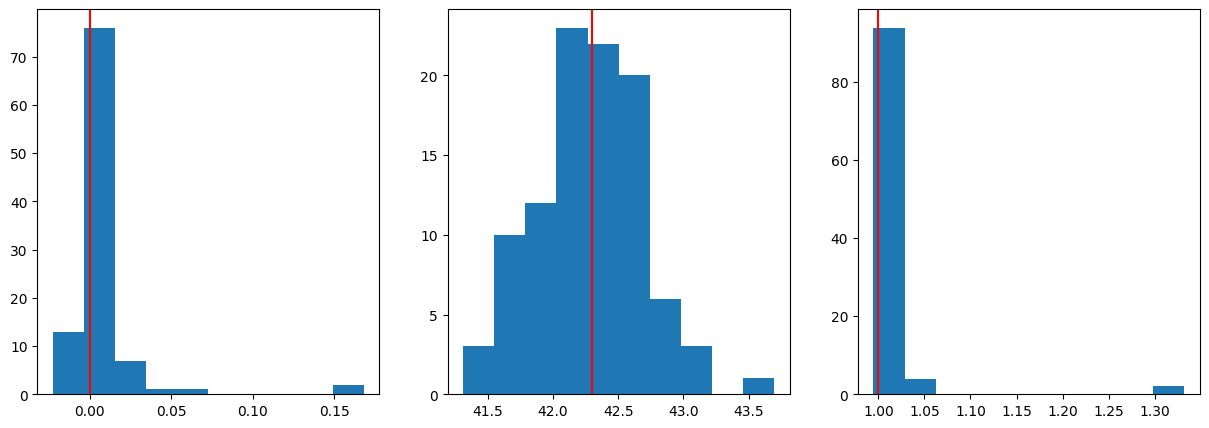

In [40]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist([p.delta_index.m for p in results])
plt.axvline(results[0].delta_index.nominal_value.m, color='red')

plt.subplot(132)
plt.hist([p.theta23.m for p in results])
plt.axvline(results[0].theta23.nominal_value.m, color='red')

plt.subplot(133)
plt.hist([p.aeff_scale.m for p in results])
plt.axvline(results[0].aeff_scale.nominal_value.m, color='red')